In [1]:
import os

import torch
from detr_config import Config
from detr_dataset import InBreastDataset, collate_fn
from detr_detection import plot_annotations, plot_results
from detr_model import DETRModel
from PIL import Image
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor

In [2]:
model_name = 'model=DETR_backbone=resnet18_queries=100_dmodel=256_layers=6'

model = DETRModel.load_from_checkpoint(
    f'./lightning_logs/{model_name}/fold_1/checkpoints/last.ckpt'
)

id2label = model.detr_model.config.id2label

image_processor = DetrImageProcessor()

test_dir = os.path.join(Config.DATASET, 'test')

test_dataset = InBreastDataset(
    images_path = test_dir,
    processor=image_processor
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 8,
    collate_fn = collate_fn,
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


c:\ProgramData\miniconda3\envs\detr-env\Lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'detr_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['detr_model'])`.
  rank_zero_warn(


In [3]:
pixel_values, labels = test_dataset.__getitem__(4)
image_id = labels['image_id'].item()
image_data = test_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join(test_dir, image_data['file_name']))
annotations = test_dataset.coco.imgToAnns[image_id]

with torch.no_grad():
    model.eval()
    outputs = model(pixel_values=pixel_values.unsqueeze(0))

postprocessed_outputs = image_processor.post_process_object_detection(
                            outputs, target_sizes=[(800, 800)], threshold=0.01, )

results = postprocessed_outputs[0]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


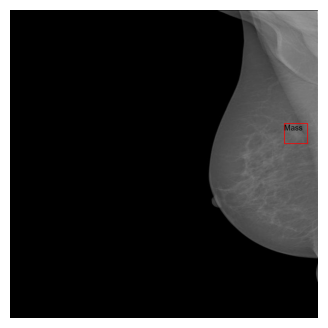

In [4]:
plot_annotations(image.copy(), annotations, id2label)


Score: 0.020462822169065475
Score: 0.020462842658162117
Score: 0.020462822169065475
Score: 0.020462827757000923
Score: 0.02046283707022667
Score: 0.020462816581130028
Score: 0.020462822169065475
Score: 0.020462848246097565
Score: 0.020462827757000923
Score: 0.02046283707022667
Score: 0.02046283707022667
Score: 0.020462827757000923
Score: 0.02046283707022667
Score: 0.020462848246097565
Score: 0.02046283707022667
Score: 0.020462842658162117
Score: 0.020462827757000923
Score: 0.02046283707022667
Score: 0.020462816581130028
Score: 0.02046283707022667
Score: 0.020462816581130028
Score: 0.02046283707022667
Score: 0.02046283707022667
Score: 0.02046280913054943
Score: 0.020462848246097565
Score: 0.020462827757000923
Score: 0.020462816581130028
Score: 0.02046281471848488
Score: 0.020462827757000923
Score: 0.020462842658162117
Score: 0.02046283707022667
Score: 0.020462816581130028
Score: 0.020462848246097565
Score: 0.020462853834033012
Score: 0.020462848246097565
Score: 0.020462816581130028
Scor

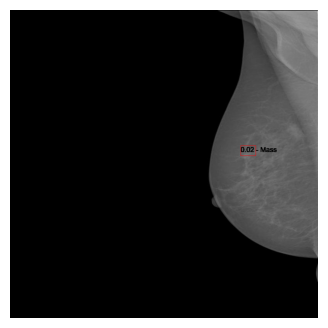

In [5]:
plot_results(image.copy(), results, id2label)